In [1]:
%matplotlib inline

In [2]:
import os
from collections import Counter
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import FIG_DIR, DATA_DIR


In [3]:
figure_data_file = os.path.join(FIG_DIR, 'fig_6_data.csv')

if not os.path.exists(figure_data_file):
    df = pd.read_csv(os.path.join(DATA_DIR, 'MFP.csv'))
    days_ref = np.load(os.path.join(DATA_DIR, 'days_date_mapping.npy')).item()
    date_ref = {v: k for k, v in days_ref.items()}
    df['date'] = df['days'].apply(lambda s: date_ref[s])

    cols = ['uid', 'days', 'food_id']
    dic = df[cols].drop_duplicates().groupby(['uid', 'days'])['food_id'].apply(list).to_dict()

    def enlist(lst):
        """ Enlist a mixture of list and str, return as original order"""
        res = []
        for i in lst:
            if isinstance(i, list) or isinstance(i, tuple):
                res.extend(i)
            else:
                if i == i:
                    res.append(i)
        return res

    # times of a food item was consumed by a user in the recent hist
    bounded_freq_dic = {}
    window_size = 7
    for user, t in sorted(dic.keys()):
        all_food = enlist([dic.get((user, n), []) for n in np.arange(t - (window_size - 1), t + 1, 1)])
        bounded_freq_dic.update({(user, t): dict(Counter(all_food))})

    def find_freq(line, ref=bounded_freq_dic):
        return ref[(line['uid'], line['days'])][line['food_id']]

    df['cnt_bounded'] = df.apply(find_freq, axis=1)
    df['is_repeat'] = df['cnt_bounded'] > 1
    df['is_repeat'] = df['is_repeat'].astype(int)

    # label meal with index
    meal_ref = {'breakfast': 0, 'lunch': 1, 'dinner': 2, 'snack': 3}
    df['meal_index'] = df['meal'].apply(lambda s: meal_ref[s])

    # temporal
    data = df.groupby(['date'])['is_repeat'].agg(['sum', 'mean']).reset_index()

    data['days'] = data['date'].apply(lambda s: days_ref[s])
    data = data.rename(str, columns={'sum': "n_repeat", 'mean': "percentage_repeat_consumption"})
    df_initial_date = '2014-09-14'
    date_format = '%Y-%m-%d'
    # initial date falls on which weekday
    df_offset = datetime.strptime(df_initial_date, date_format).weekday() + 1
    # test date after passing 7 training & 1 validation days
    data['weekday'] = data['days'].apply(lambda t: (t + df_offset - 1) % 7 + 1)
    weekday_ref = {7: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
    data['day'] = data['weekday'].apply(lambda s: weekday_ref[s][:3])
    data.to_csv(figure_data_file, index=False)


In [4]:
def plot_fig7(df, col='percentage_repeat_consumption'):
    figure_name = os.path.join(FIG_DIR, 'paper_fig_7.png')

    plt.rc('pdf', fonttype=42)
    sns.set(style="ticks")
    sns.set_context('paper', font_scale=1.3)
    plt.subplots(figsize=(6, 3))

    ax = sns.boxplot(x="day", y=col, data=df, showfliers=False,
                     order=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", 'Sun'],
                     linewidth=2.5, color='darkgrey', )
    ax.grid(ls="dotted")
    ax.set_ylabel("% Repeat consumption")
    ax.set_xlabel("Day")
    sns.despine(offset=10, trim=True)
    plt.tight_layout()
    plt.savefig(figure_name, dpi=200, transparent=False, bbox_inches='tight', pad_inches=0.0)
    plt.show()


In [5]:
data = pd.read_csv(figure_data_file)

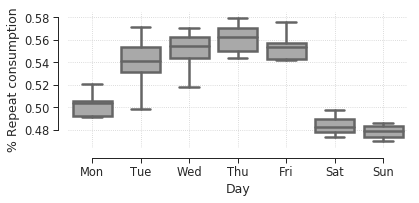

In [6]:
plot_fig7(data.iloc[7:,])